In [1]:
# Allowed Libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score



Plot the graph using Network.

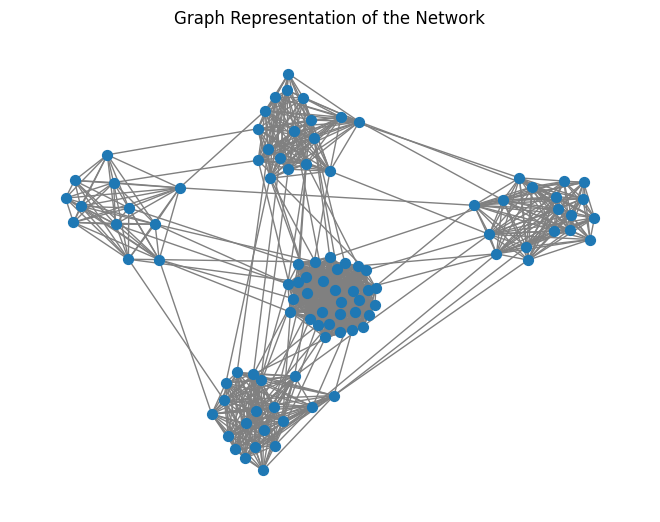

In [2]:
data0_path = '/content/assignment4_data0.txt'
G = nx.read_edgelist(data0_path) # Reads edgelist from file

# Make the graph
nx.draw(G, node_size=50, edge_color="gray")
plt.title("Graph Representation of the Network")
plt.show()



What is the average path length of the graph? (You may use the Networkx function)

In [3]:
avg_path_length = nx.average_shortest_path_length(G)
print('The average path lenght of the graph is: ', avg_path_length)

The average path lenght of the graph is:  2.2414141414141415


• Write a function titled girvan_newman that implements the Girvan-
Newman algorithm
• Do not use the girvan_newman function from Networkx
- You may use the function edge_betweenness_centrality function
• The function should have the following inputs:
- G is a Networkx representation of the graph.
- k is the number of communities the algorithm returns. Think of this as the stopping
condition for the loop in the algorithm
• The function should have the following ouput:
- communities which is a list of Networkx graphs such that each graph in the list is a
community derived from G

In [40]:
def girvan_newman(G, k):
    G_copy = G.copy() # Copy of graph
    while nx.number_connected_components(G_copy) < k:
        betweenness = nx.edge_betweenness_centrality(G_copy) # Edge centrality
        max_betweenness_edge = max(betweenness, key=betweenness.get) # Edge with highest betweenness centrality
        G_copy.remove_edge(*max_betweenness_edge)

    communities = [G_copy.subgraph(c).copy() for c in nx.connected_components(G_copy)]

    return communities

• Apply your girvan_newman algorithm on the previously loaded
dataset (assignment4_data0.txt) using a k value that was deemed to be
the correct number of communities from the visual inspection done
earlier
• Plot the graph as before except this time colour the vertices according to
the derived communities from the girvan_newman algorithm

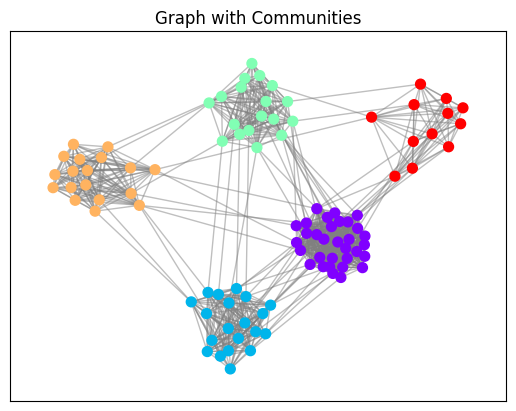

In [5]:
k_value = 5 # As seen from the graph the number of communities is 5
communities = girvan_newman(G, k=k_value)

color_map = {}
for i, community in enumerate(communities):
    for node in community.nodes():
        color_map[node] = i  # Color based on the community index

node_colors = [color_map[node] for node in G.nodes()]

# Plot
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, cmap=plt.cm.rainbow)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
plt.title("Graph with Communities")
plt.show()



What is the intra-community density for each of the communities?

In [46]:
intra_community_densities = {}

# Calculating the intra-community density
for i, community in enumerate(communities):
    num_nodes = len(community.nodes())
    num_edges = len(community.edges())
    density = (2 * num_edges) / (num_nodes * (num_nodes - 1))
    intra_community_densities[f"Community {i+1}"] = density

# Print the densities
for community, density in intra_community_densities.items():
    print(f"{community}: {density:.4f}")


Community 1: 0.9073
Community 2: 0.9000
Community 3: 0.8824
Community 4: 0.9020
Community 5: 0.8939


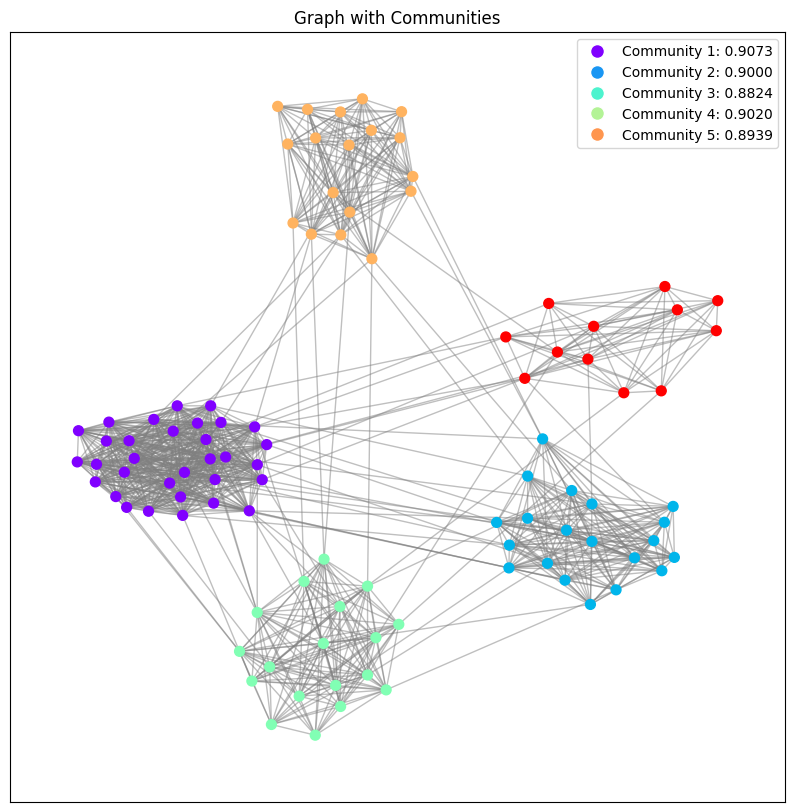

In [7]:
color_map = {}
for i, community in enumerate(communities):
    for node in community:
        color_map[node] = i

node_colors = [color_map[node] for node in G.nodes()]

# Plot of commuties
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, cmap=plt.cm.rainbow)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')

# Legend for the communities and intrs-community densities
unique_communities = list(set(node_colors))
labels = [f"Community {i+1}: {intra_community_densities[f'Community {i+1}']:.4f}" for i in unique_communities]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.rainbow(i/len(unique_communities)), markersize=10) for i in unique_communities]
plt.legend(handles, labels, loc="best")

plt.title("Graph with Communities")
plt.show()

What is the inter-community density for the graph?

In [8]:
inter_community_edges = 0

# Assiging node to community
node_to_community = {}
for i, community in enumerate(communities):
    for node in community.nodes():
        node_to_community[node] = i

for edge in G.edges():
    node1, node2 = edge
    # To check if the edge connects nodes from different communities
    if node_to_community[node1] != node_to_community[node2]:
        inter_community_edges += 1

total_nodes = len(G.nodes()) # Total # of nodes

# Calculate inter-community density
inter_community_density = inter_community_edges / (total_nodes * (total_nodes - 1) / 2)
print(f"Inter-Community Density: {inter_community_density:.4f}")


Inter-Community Density: 0.0121


• Implement the Heymann Garcia-Molina algorithm to induce the taxonomy

In [31]:
# Opening File
file_path = '/content/assignment4_carnivora.txt'
tag_docs = {}

with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        document = parts[0]
        family = parts[2]  # Third element is family
        genus = parts[3]   # Fourth element is genus

        if family not in tag_docs:
            tag_docs[family] = []
        if genus not in tag_docs:
            tag_docs[genus] = []

        tag_docs[family].append(document)
        tag_docs[genus].append(document)

# Get all unique tags and documents
all_tags = list(tag_docs.keys())
all_documents = sorted({doc for docs in tag_docs.values() for doc in docs})

# Tag vectores
D = len(all_documents)
tag_vectors = np.zeros((len(all_tags), D))
doc_to_idx = {doc: idx for idx, doc in enumerate(all_documents)}
for tag_idx, tag in enumerate(all_tags):
    for doc in tag_docs[tag]:
        doc_idx = doc_to_idx[doc]
        tag_vectors[tag_idx][doc_idx] = 1  # 1 if tag annotates the document

# Calculate pairwise cosine similarity between all tag vectors
cosine_sim = cosine_similarity(tag_vectors)

alpha = 0.5
G = nx.Graph()
for i in range(len(all_tags)):
    G.add_node(all_tags[i])

for i in range(len(all_tags)):
    for j in range(i + 1, len(all_tags)):
        if cosine_sim[i, j] > alpha:
            G.add_edge(all_tags[i], all_tags[j])

centrality = nx.closeness_centrality(G) # Calculate closeness centrality for all vertices
root_tag = max(centrality, key=centrality.get)
sorted_tags = sorted(centrality, key=centrality.get, reverse=True)

# Create a taxonomy with the root bieng the highest centrality tag
taxonomy_tree = nx.DiGraph()
taxonomy_tree.add_node(root_tag)

for tag in sorted_tags[1:]:
    # Find the most similar tag to the current tag
    parent_tag = max(taxonomy_tree.nodes, key=lambda t: cosine_sim[all_tags.index(tag)][all_tags.index(t)])
    taxonomy_tree.add_edge(parent_tag, tag)

taxonomy_edges = list(taxonomy_tree.edges)
taxonomy_edges[:12]

[('carnivora', 'hyaenidae'),
 ('carnivora', 'viverridae'),
 ('carnivora', 'felidae'),
 ('carnivora', 'nandiniidae'),
 ('carnivora', 'canidae'),
 ('carnivora', 'herpestidae'),
 ('carnivora', 'mustelidae'),
 ('carnivora', 'ursidae'),
 ('carnivora', 'mephitidae'),
 ('carnivora', 'eupleridae'),
 ('carnivora', 'procyonidae'),
 ('carnivora', 'ailuridae')]

How many tags are there in each level of your induced taxonomy?

In [47]:
levels = {}
queue = [(root_tag, 0)]  # Root at level 0
while queue:
    node, level = queue.pop(0)

    if level not in levels:
        levels[level] = 0
    levels[level] += 1

    for child in taxonomy_tree.successors(node):
        queue.append((child, level + 1))

levels

{0: 1, 1: 12}

Calculate the F1 score of your induced taxonomy using the ground truth axioms found in assignment4_carnivora_gold_standard.txt. The F1 score is a performance metric for classification problems and can be calculated using Sklearn's metric package.

In [24]:
# Load the ground truth axioms from the gold standard file
ground_truth_edges = []

with open('/content/assignment4_carnivora_gold_standard.txt', 'r') as file:
    for line in file:
        parent, child = line.strip().split()
        ground_truth_edges.append((parent, child))

# Extract the induced taxonomy edges from the current tree
induced_edges = list(taxonomy_tree.edges)

# Create sets of edges for comparison
induced_set = set(induced_edges)
ground_truth_set = set(ground_truth_edges)

# True positives: edges that exist in both induced and ground truth
true_positives = induced_set & ground_truth_set

# False positives: edges in induced that are not in ground truth
false_positives = induced_set - ground_truth_set

# False negatives: edges in ground truth that are not in induced
false_negatives = ground_truth_set - induced_set

# Create binary vectors for F1 score calculation (1 if an edge exists, 0 otherwise)
y_true = [1 if edge in ground_truth_set else 0 for edge in induced_edges + ground_truth_edges]
y_pred = [1 if edge in induced_set else 0 for edge in induced_edges + ground_truth_edges]

# Calculate F1 score using sklearn's f1_score
f1 = f1_score(y_true, y_pred)

f1


0.3096774193548387

Plot the F1 scores obtained at a values from 0.05 to 0.95 in increments of 0.05.

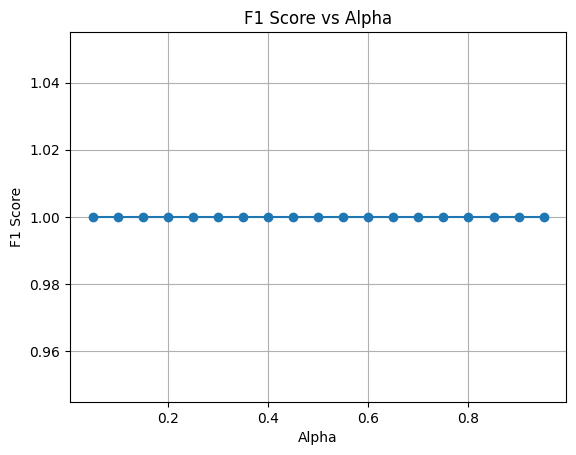

In [35]:
alpha_values = np.arange(0.05, 1.0, 0.05)
f1_scores = []


for alpha in alpha_values: # Loop over different alpha
    G = nx.Graph()
    for i in range(len(all_tags)):
        G.add_node(all_tags[i])
    for i in range(len(all_tags)):
        for j in range(i + 1, len(all_tags)):
            if cosine_sim[i, j] > alpha:
                G.add_edge(all_tags[i], all_tags[j])

    centrality = nx.closeness_centrality(G)
    root_tag = max(centrality, key=centrality.get)
    sorted_tags = sorted(centrality, key=centrality.get, reverse=True)
    taxonomy_tree = nx.DiGraph() # New taxonomy tree
    taxonomy_tree.add_node(root_tag)

    for tag in sorted_tags[1:]:
        parent_tag = max(taxonomy_tree.nodes, key=lambda t: cosine_sim[all_tags.index(tag)][all_tags.index(t)])
        taxonomy_tree.add_edge(parent_tag, tag)

    induced_edges = list(taxonomy_tree.edges) # Induced edges

    # Create binary vectors for F1 score calculation
    y_true = [1 if edge in ground_truth_set else 0 for edge in induced_edges + ground_truth_edges]
    y_pred = [1 if edge in induced_set else 0 for edge in induced_edges + ground_truth_edges]
    f1 = f1_score(y_true, y_pred)
    f1_scores.append(f1)

# Plot
plt.plot(alpha_values, f1_scores, marker='o')
plt.title('F1 Score vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()
